# Twitter sentiment analysis with TFIDF Vectorizer

In [1]:

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.examples import sentences 
from spacy.cli import download  
# download("en_core_web_sm")
import spacy
import preprocess_kgptalkie as ps  # import the cleaning package
import re  # regex
from dython.model_utils import metric_graph
from dython.nominal import associations
from wordcloud import WordCloud
# from sklearn import set_config
# set_config(display="diagram")
from sklearn import set_config
set_config(display="diagram")
import plotly.express as px

In [2]:
# reading the csv file
df = pd.read_csv("airline_tweets.csv")
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df = df.loc[:,["airline","text","airline_sentiment"]] # rassigning df
df.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
df["sentiment_encoded"] = df.airline_sentiment.apply(lambda x: (-1) if x == "negative" else (0) if x == "neutral" else (1) )

In [6]:
df[df.duplicated().values]

,airline,text,airline_sentiment,sentiment_encoded
331,Virgin America,@VirginAmerica Thanks!,positive,1
515,United,@united thanks,positive,1
1477,United,@united thank you!,positive,1
1864,United,@united thank you,positive,1
1938,United,@united thank you,positive,1
...,...,...,...,...
13995,American,@AmericanAir 800 number will not even let you...,negative,-1
14386,American,@AmericanAir I want to speak to a human being!...,negative,-1
14392,American,@AmericanAir no response to DM or email yet. ...,negative,-1
14543,American,@AmericanAir should reconsider #usairways acqu...,negative,-1


In [7]:
df.drop_duplicates(keep ="first", inplace= True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.rename({"text" :"tweets"}, axis =1, inplace = True)

In [10]:
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [11]:
df.dropna(how = "any", inplace = True)

In [12]:
df.shape
df.head()

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,0
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive,1
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative,-1
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative,-1


In [13]:
df.airline_sentiment.value_counts().index


Index(['negative', 'neutral', 'positive'], dtype='object')

In [14]:
fig= px.pie(df.airline_sentiment.value_counts(), values = df.airline_sentiment.value_counts().values, names =df.airline_sentiment.value_counts().index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Preprocessing and removing stopwords

In [15]:
# def get_clean(x):
#     x = str(x).lower().replace('\\', '').replace('_', ' ')
#     x = ps.cont_exp(x)
#     x = ps.remove_emails(x)
#     x = ps.remove_urls(x)
#     x = ps.remove_html_tags(x)
#     x = ps.remove_rt(x)
#     x = ps.remove_accented_chars(x)
#     x = ps.remove_special_chars(x)
#     x = re.sub("(.)\\1{2,}", "\\1", x)
#     return x


#cleaning the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [16]:
df.tweets = df.tweets.apply(lambda x: clean_tweets(x))

In [17]:
tweets= df.tweets.str.split(expand = True,n=1)[1]
df.tweets= tweets
df.isna().sum()

airline                0
tweets               108
airline_sentiment      0
sentiment_encoded      0
dtype: int64

In [42]:
df.tweets

0                                                    said.
1        you've added commercials to the experience... ...
2        didn't today... Must mean I need to take anoth...
3        really aggressive to blast obnoxious "entertai...
4                     it's a really big bad thing about it
                               ...                        
14635         you we got on a different flight to Chicago.
14636    over 20 minutes Late Flight. No warnings or co...
14637             bring American Airlines to #BlackBerry10
14638    have my money, you change my flight, and don't...
14639    have 8 ppl so we need 2 know how many seats ar...
Name: tweets, Length: 14344, dtype: object

In [18]:
# view sample cleaned text
df.dropna(inplace= True)
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [19]:
df.to_csv("dataframe.csv", index = False)

In [20]:
X= df.tweets
y= df.sentiment_encoded

# Pipeline with needed libraries

In [21]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB

In [22]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [23]:
model = Pipeline([('Vect',TfidfVectorizer(max_features = 100000, ngram_range =(1,2),stop_words = 'english')),
                  #('to_dense', DenseTransformer()), 
                   ('mnb', MultinomialNB(alpha=0.01))
                 
                  ])

In [43]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [44]:
model.fit(X_train, y_train)

Pipeline(steps=[('Vect',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.01))])

In [45]:
y_pred = model.predict(X_test )
y_pred

array([-1, -1,  0, ..., -1,  0, -1], dtype=int64)

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [47]:
accuracy_score(y_test, y_pred)

0.7371906587661206

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.92      0.84      1830
           0       0.59      0.39      0.47       576
           1       0.71      0.43      0.54       463

    accuracy                           0.74      2869
   macro avg       0.69      0.58      0.61      2869
weighted avg       0.72      0.74      0.71      2869



In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.92      0.84      1830
           0       0.59      0.39      0.47       576
           1       0.71      0.43      0.54       463

    accuracy                           0.74      2869
   macro avg       0.69      0.58      0.61      2869
weighted avg       0.72      0.74      0.71      2869



In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1692,  100,   38],
       [ 309,  222,   45],
       [ 209,   53,  201]], dtype=int64)

In [51]:
pd.DataFrame(cm)

,0,1,2
0,1692,100,38
1,309,222,45
2,209,53,201


<AxesSubplot:>

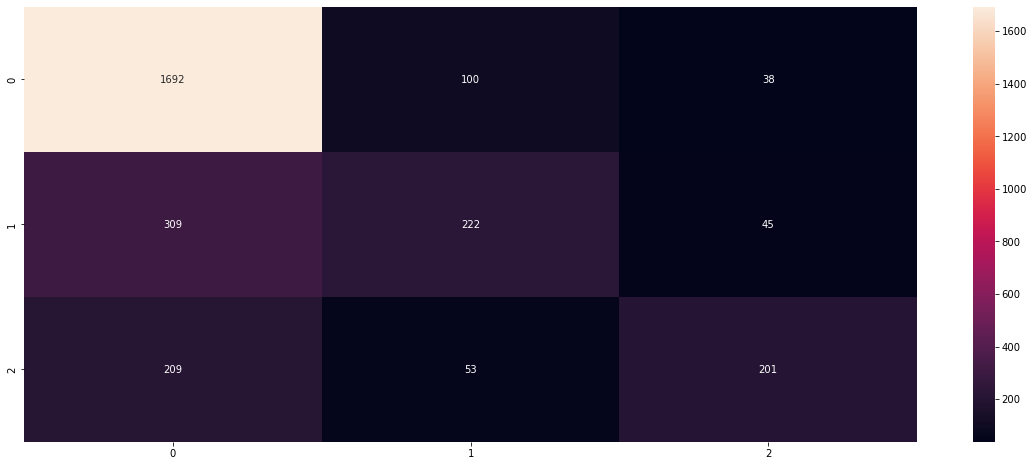

In [52]:
fig, ax = plt.subplots(figsize = (20,8))
sns.heatmap(cm, annot = True, fmt = "d",)

In [53]:
y_proba = model.predict_proba(X_test)
y_proba

array([[6.31459695e-01, 2.12026144e-01, 1.56514161e-01],
       [9.79930171e-01, 1.11371224e-02, 8.93270634e-03],
       [2.95320888e-01, 7.03595784e-01, 1.08332855e-03],
       ...,
       [9.97046685e-01, 2.15514731e-03, 7.98167873e-04],
       [1.02065053e-01, 8.87355428e-01, 1.05795187e-02],
       [6.31459695e-01, 2.12026144e-01, 1.56514161e-01]])

In [54]:
import joblib
joblib.dump(model,"model_twitter.joblib")

['model_twitter.joblib']

In [55]:
df

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,said.,neutral,0
1,Virgin America,you've added commercials to the experience... ...,positive,1
2,Virgin America,didn't today... Must mean I need to take anoth...,neutral,0
3,Virgin America,"really aggressive to blast obnoxious ""entertai...",negative,-1
4,Virgin America,it's a really big bad thing about it,negative,-1
...,...,...,...,...
14635,American,you we got on a different flight to Chicago.,positive,1
14636,American,over 20 minutes Late Flight. No warnings or co...,negative,-1
14637,American,bring American Airlines to #BlackBerry10,neutral,0
14638,American,"have my money, you change my flight, and don't...",negative,-1


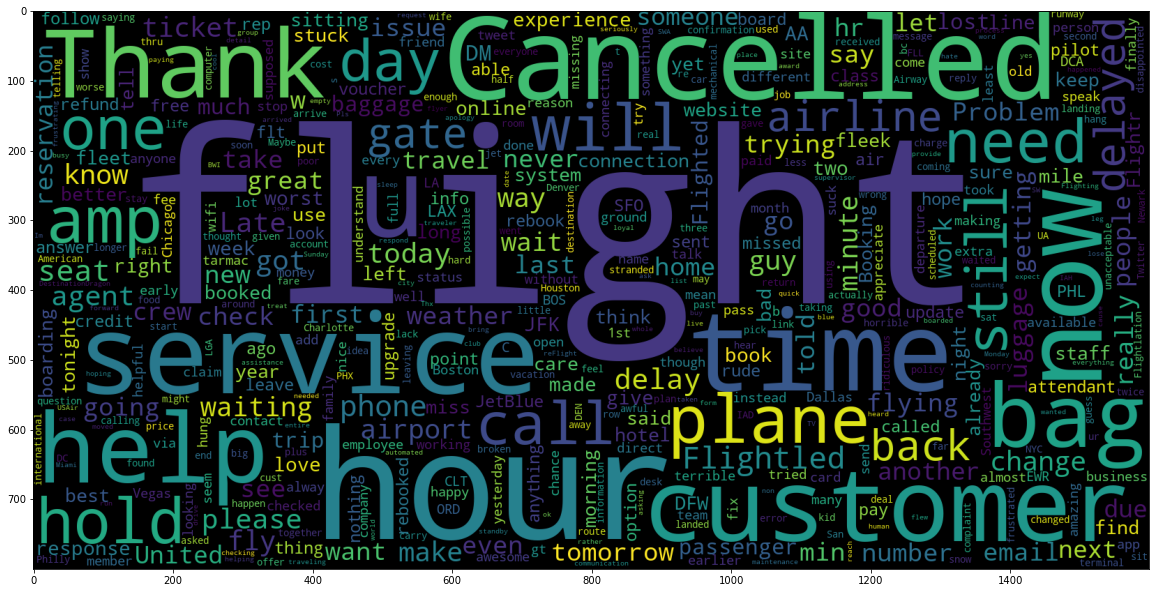

In [56]:
text = "".join(df['tweets'])
fig, ax = plt.subplots(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,collocations=False).generate(text)
ax.imshow(wc);

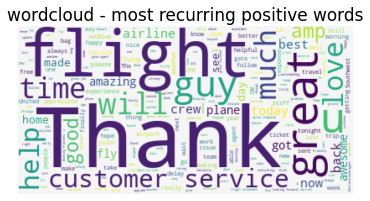

In [57]:
fig, ax = plt.subplots() 
super = df.loc[:,["tweets","airline_sentiment"]]
text = "".join(super[super.airline_sentiment == "positive"].tweets)
wc= WordCloud(max_words = 1000,background_color="whitesmoke", random_state=42,normalize_plurals=True).generate(text)
plt.title("wordcloud - most recurring positive words", fontsize = 17)
plt.axis("off")
#plt.tight_layout(pad=0)
ax.imshow(wc,interpolation="bilinear")


In [58]:
super = df.loc[:,["tweets","airline_sentiment"]]
super[super.airline_sentiment == "negative"].tweets

3        really aggressive to blast obnoxious "entertai...
4                     it's a really big bad thing about it
5        would pay $30 a flight for seats that didn't h...
15                                  schedule is still MIA.
17       flew from NYC to SFO last week and couldn't fu...
                               ...                        
14631    for nothing on getting us out of the country a...
14633    flight was Cancelled Flightled, leaving tomorr...
14634                              on cue with the delays👌
14636    over 20 minutes Late Flight. No warnings or co...
14638    have my money, you change my flight, and don't...
Name: tweets, Length: 9076, dtype: object

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

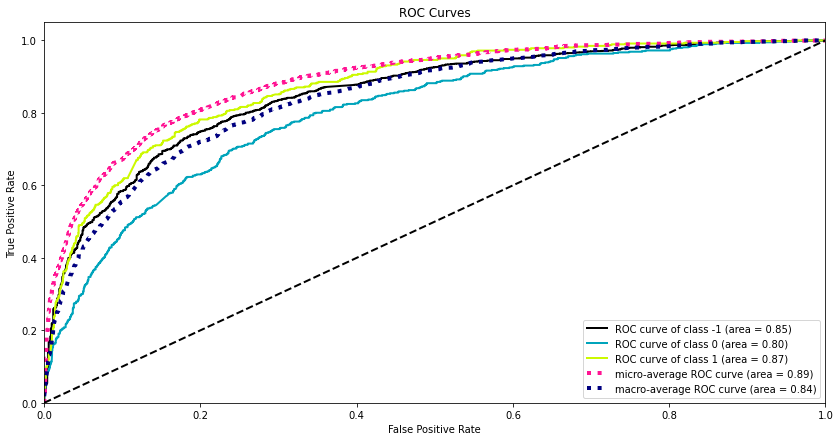

In [59]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(14,7))
skplt.metrics.plot_roc(y_test, y_proba,ax= ax)

In [60]:
text = df['tweets'][:4]
text

0                                                said.
1    you've added commercials to the experience... ...
2    didn't today... Must mean I need to take anoth...
3    really aggressive to blast obnoxious "entertai...
Name: tweets, dtype: object